In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from util.combine_stream import *
import os
MOA_FILEPATH = '~/Desktop/3H03/moa-release-2023.04.0/lib'

In [2]:
directory = "/Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/IOPS"
files = os.listdir(directory)
files.sort()

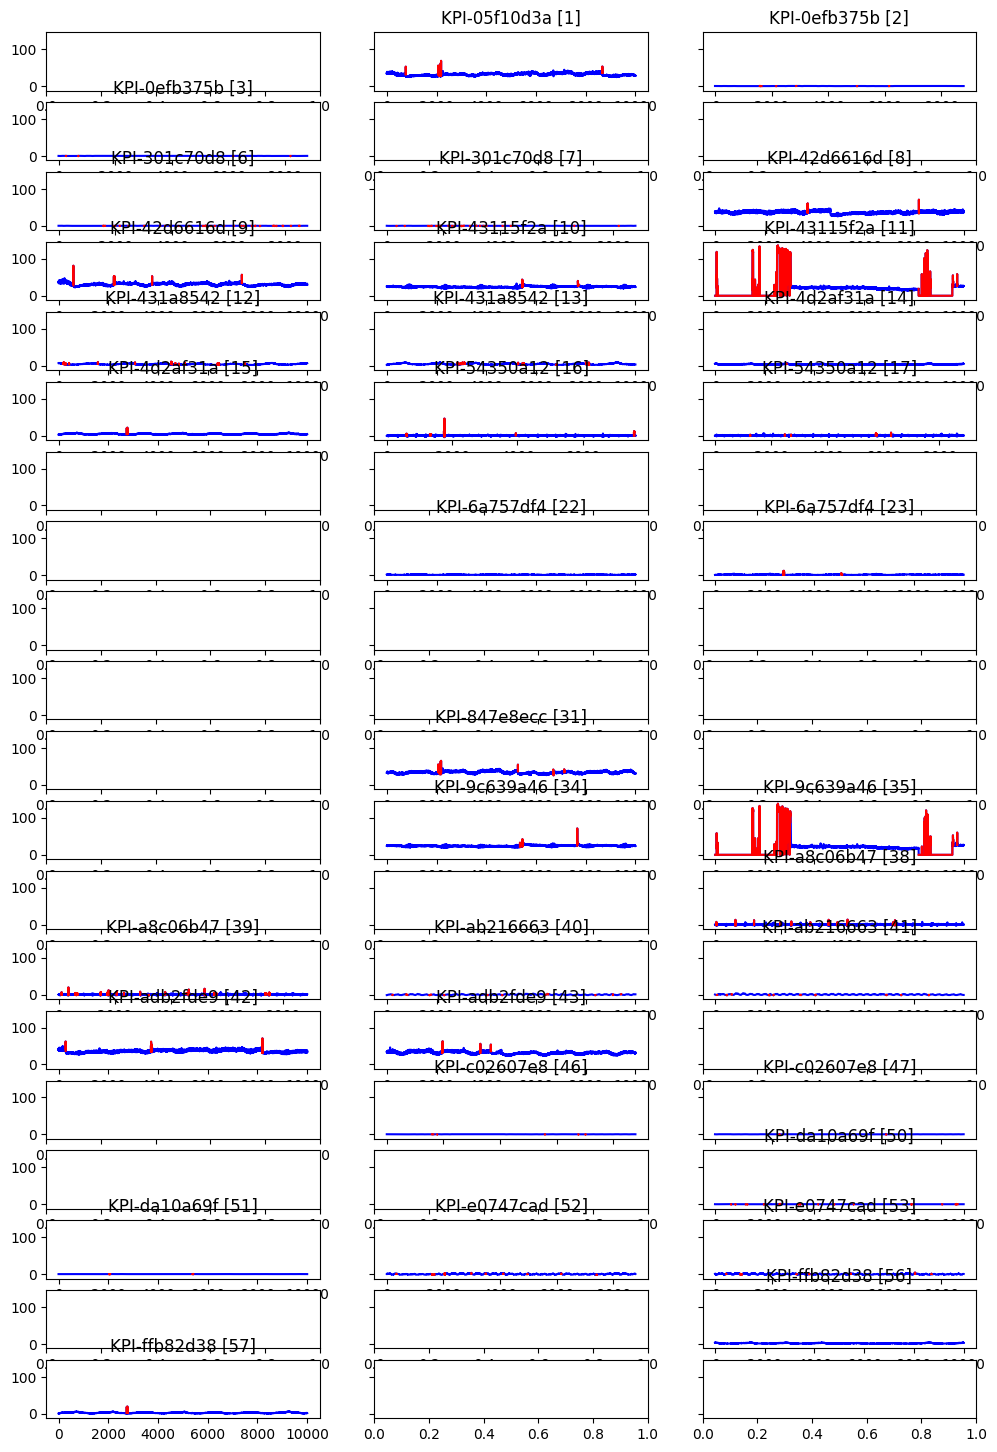

In [81]:
fig, ax = plt.subplots(int(len(files)//3)+1,3,figsize=(12,18), sharey=True)
for i in range(len(files)):
    X, y = get_arff_data_labels(os.path.join(directory, files[i]))
    if max(X) < 150:
        plot_anomaly(X, y, ax[int(i//3)][i%3], 0, 10000, title=f'{files[i][:12]} [{i}]')

KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.train.arff
KPI-ab216663-dcc2-3a24-b1ee-2c3e550e06c9.train.arff
X1 shape: (8784, 1)
X2 shape: (11138, 1)
Stream 1 # anomalies: 7
Stream 2 # anomalies: 12


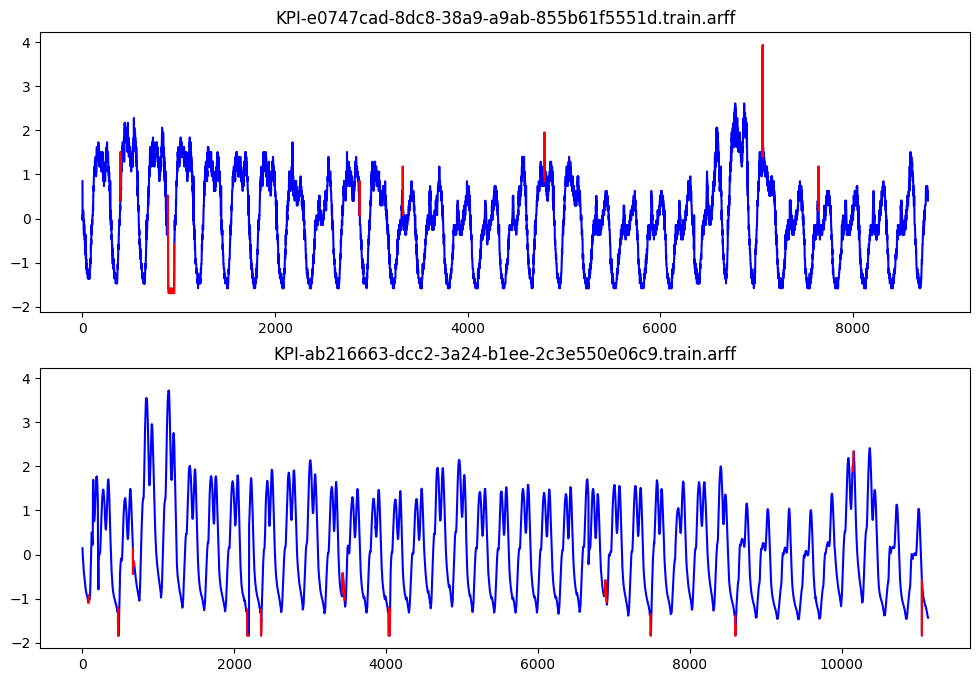

In [229]:
stream1 = files[53]
stream2 = files[41]
# stream1 = files[42]
# stream2 = files[43]
print(stream1)
X1, y1 = get_arff_data_labels(os.path.join(directory, stream1))
print(stream2)
X2, y2 = get_arff_data_labels(os.path.join(directory, stream2))
anom_int_1 = find_anomaly_intervals(y1)
anom_int_2 = find_anomaly_intervals(y2)
print('X1 shape:', X1.shape)
print('X2 shape:', X2.shape)
print('Stream 1 # anomalies:', len(anom_int_1))
print('Stream 2 # anomalies:', len(anom_int_2))
fig, ax = plt.subplots(2,1,figsize=(12,8), sharey=True)
plot_anomaly(X1, y1, ax[0], title=stream1)
plot_anomaly(X2, y2, ax[1], title=stream2)

In [265]:
# configure details
n_trial = 1
length = 8784
n_drift = 1
drift_type = "abrupt"
p_drift = 0.45
n_before = 0.5
width = 1 # only applies to gradual
min_width = 1200 # min segment length (source or drift)

# generate split_index
anom_ints = [anom_int_1, anom_int_2]
seq_drift_before = get_seq_drift_before(n_before, n_drift)
split_index = get_split_index(anom_ints, p_drift, n_drift, seq_drift_before, length, min_width)
print(split_index)
print(seq_drift_before)

filename = f"IOPS_p{int(p_drift*100)}_{drift_type}_b{int(n_before*100)}_{n_trial}"
print(filename)

[2882, 4797]
[True, False]
IOPS_p45_abrupt_b50_1


In [266]:
params_file = "data/synthetic/params_used.csv"
params = {
    "length": [length],
    "number_of_drifts": [n_drift],
    "drift_type": [drift_type],
    "percentage_drift": [p_drift],
    "amount_anomalies_before": [n_before],
    "width": [width],
    "stream1": [stream1],
    "stream2": [stream2],
    "filename": [filename],
    "split_index": [split_index]
}
params_df = pd.DataFrame(params)
old_params_df = pd.read_csv(params_file, index_col=0)
if filename in old_params_df.filename.tolist():
    i = old_params_df.filename.tolist().index(filename)
    old_params_df.iloc[i] = {p:params[p][0] for p in params}
    params_df_sorted = old_params_df.sort_values(by="filename")
else:
    params_df = pd.concat([old_params_df, params_df], ignore_index=True)
    params_df_sorted = params_df.sort_values(by="filename")
params_df_sorted.to_csv(params_file)
params_df_sorted.head(20)

,length,number_of_drifts,drift_type,percentage_drift,amount_anomalies_before,width,stream1,stream2,filename,split_index
0,229900,2,abrupt,0.15,0.5,1,MBA_ECG14046_data_1.arff,MBA_ECG14046_data_21.arff,ECG_p15_abrupt_b50_1,[]
1,161280,2,abrupt,0.25,0.5,1,MBA_ECG803_data.arff,MBA_ECG820_data.arff,ECG_p25_abrupt_b50_1,[]
2,230400,2,abrupt,0.35,0.5,1,MBA_ECG820_data.arff,MBA_ECG803_data.arff,ECG_p35_abrupt_b50_1,[]
3,114950,3,abrupt,0.45,0.5,1,MBA_ECG14046_data_21.arff,MBA_ECG14046_data_1.arff,ECG_p45_abrupt_b50_1,[]
4,230400,1,abrupt,0.05,0.5,1,MBA_ECG803_data.arff,MBA_ECG820_data.arff,ECG_p5_abrupt_b50_1,[]
5,138240,1,abrupt,0.05,0.5,1,MBA_ECG820_data.arff,MBA_ECG803_data.arff,ECG_p5_abrupt_b50_2,[]
6,117003,1,abrupt,0.15,0.5,1,KPI-adb2fde9-8589-3f5b-a410-5fe14386c7af.test....,KPI-adb2fde9-8589-3f5b-a410-5fe14386c7af.train...,IOPS_p15_abrupt_b50_1,[]
7,146204,1,abrupt,0.25,0.5,1,KPI-55f8b8b8-b659-38df-b3df-e4a5a8a54bc9.train...,KPI-05f10d3a-239c-3bef-9bdc-a2feeb0037aa.train...,IOPS_p25_abrupt_b50_1,"[93514, 130553]"
8,8784,2,abrupt,0.35,0.5,1,KPI-ab216663-dcc2-3a24-b1ee-2c3e550e06c9.train...,KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.test....,IOPS_p35_abrupt_b50_1,"[1597, 2350, 4052, 6170]"
10,8784,1,abrupt,0.45,0.5,1,KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.train...,KPI-ab216663-dcc2-3a24-b1ee-2c3e550e06c9.train...,IOPS_p45_abrupt_b50_1,"[2882, 4797]"


In [267]:
# cut file1 so we can do the drift
input_file = os.path.join(directory, stream1)
output_dir = "/Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/"
f1_intermed = split_arff(input_file, split_index, filename, output_dir)

Generated file: /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.train_IOPS_p45_abrupt_b50_1_0.arff
Generated file: /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.train_IOPS_p45_abrupt_b50_1_1.arff
Generated file: /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.train_IOPS_p45_abrupt_b50_1_2.arff


In [268]:
# cut file2 so we can do the drift
input_file = os.path.join(directory, stream2)
output_dir = "/Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/"
f2_intermed = split_arff(input_file, split_index, filename, output_dir)

Generated file: /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-ab216663-dcc2-3a24-b1ee-2c3e550e06c9.train_IOPS_p45_abrupt_b50_1_0.arff
Generated file: /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-ab216663-dcc2-3a24-b1ee-2c3e550e06c9.train_IOPS_p45_abrupt_b50_1_1.arff
Generated file: /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-ab216663-dcc2-3a24-b1ee-2c3e550e06c9.train_IOPS_p45_abrupt_b50_1_2.arff


In [269]:
streams = []
f_intermed = f1_intermed
for i in range(len(split_index) + 1):
    streams.append(get_moa_stream_from_arff(f_intermed[i]))
    if f_intermed == f1_intermed:
        f_intermed = f2_intermed
    else:
        f_intermed = f1_intermed

positions = split_index

for i in range(1, len(streams)):
    if i > 1:
        drift_stream = generate_moa_abrupt_stream(drift_stream, streams[i], positions[i-1])
    else:
        drift_stream = generate_moa_abrupt_stream(streams[0], streams[1], positions[0])

In [270]:
trial = "amount_drift"
output_path = f'/Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/{trial}/{filename}.arff'
print(generate_moa_command(MOA_FILEPATH, drift_stream, output_path, length))

!cd ~/Desktop/3H03/moa-release-2023.04.0/lib && java -cp moa.jar -javaagent:sizeofag-1.0.4.jar moa.DoTask "WriteStreamToARFFFile  -s (ConceptDriftStream -s (ConceptDriftStream -s (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.train_IOPS_p45_abrupt_b50_1_0.arff -c 0) -d (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-ab216663-dcc2-3a24-b1ee-2c3e550e06c9.train_IOPS_p45_abrupt_b50_1_1.arff -c 0) -p 2882 -w 1) -d (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.train_IOPS_p45_abrupt_b50_1_2.arff -c 0) -p 4797 -w 1) -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/amount_drift/IOPS_p45_abrupt_b50_1.arff -m 8784"


In [271]:
!cd ~/Desktop/3H03/moa-release-2023.04.0/lib && java -cp moa.jar -javaagent:sizeofag-1.0.4.jar moa.DoTask "WriteStreamToARFFFile  -s (ConceptDriftStream -s (ConceptDriftStream -s (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.train_IOPS_p45_abrupt_b50_1_0.arff -c 0) -d (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-ab216663-dcc2-3a24-b1ee-2c3e550e06c9.train_IOPS_p45_abrupt_b50_1_1.arff -c 0) -p 2882 -w 1) -d (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/intermediate/KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.train_IOPS_p45_abrupt_b50_1_2.arff -c 0) -p 4797 -w 1) -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/amount_drift/IOPS_p45_abrupt_b50_1.arff -m 8784"



{M}assive {O}nline {A}nalysis
Version:  23.04 April 2023
Copyright: (C) 2007-2023 University of Waikato, Hamilton, New Zealand
Web: http://moa.cms.waikato.ac.nz/

                                                                               
Task completed in 0.18s (CPU time)

Stream written to ARFF file /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/IOPS/amount_drift/IOPS_p45_abrupt_b50_1.arff


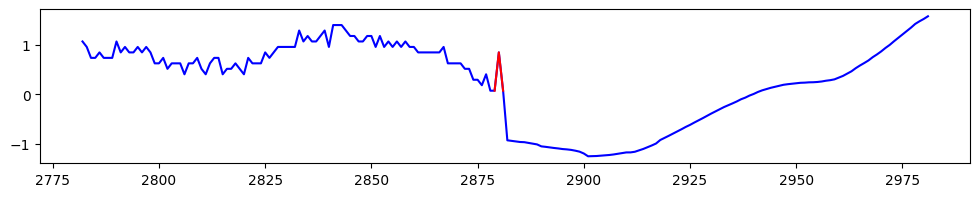

In [272]:
X, y = get_arff_data_labels(output_path)
fig, ax = plt.subplots(1,1,figsize=(12,2))
plot_anomaly(X, y, ax, split_index[0] - 100, split_index[0] + 100)

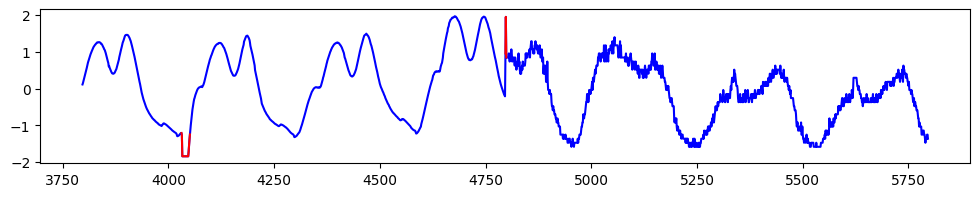

In [273]:
fig, ax = plt.subplots(1,1,figsize=(12,2))
plot_anomaly(X, y, ax, split_index[1] - 1000, split_index[1] + 1000)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,2))
plot_anomaly(X, y, ax, split_index[2] - 1000, split_index[2] + 1000)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,2))
plot_anomaly(X, y, ax, split_index[3] - 1000, split_index[3] + 1000)

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(12,2))
# plot_anomaly(X, y, ax, split_index[4] - 1000, split_index[4] + 1000)

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(12,2))
# plot_anomaly(X, y, ax, split_index[5] - 1000, split_index[5] + 1000)

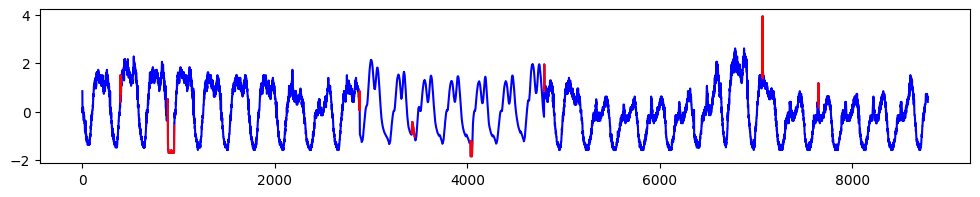

In [274]:
fig, ax = plt.subplots(1,1,figsize=(12,2))
plot_anomaly(X, y, ax)